# DMS sequence convolutional NN

I use DMS experiments as a training set and try to predict the effect of mutations in a LOPO fashion.

## Obtain the training vectors
For this sequence convolutional network a dms experiment consitutes a single training point. All the mutations are predicted at the same time.

The y vector is actually a dictionary with target values for the raw and quantile normalised fitness. Each of them is a dictionary with the dms_id as key. Each element is a vector with the position along the protein in the first axis and the aa2 on the second. For ease of processing I load them from the pre-processed dataframe that I define in dms_training_data_creation.

The x vector is also a dictionary with the dms_id as key. Each element is a vector with the position along the protein in the first axis, the aa2 on the second, and the feature (channel) on the third. The features in this case are loaded directly from the original data and not from the pre-processed dataframe.

In [183]:
import numpy as np
import pandas as pd

df = pd.read_csv('/home/saul/master_thesis_work/dataset/dms/dms_training.csv')

y = {
    'reported_fitness': dict(), 
    'reported_fitness_quantile': dict()
}
for study in set(df.dms_id):
    y['reported_fitness'][study] = np.zeros((
        max(df[df.dms_id == study].feature_index) + 1,
        20)
    )
    y['reported_fitness_quantile'][study] = np.zeros((
        max(df[df.dms_id == study].feature_index) + 1,
        20,
    ))
    y['reported_fitness'][study][:,:] = np.nan
    y['reported_fitness_quantile'][study][:,:] = np.nan
    for feature_index in sorted(set(df[df.dms_id == study].feature_index)):
        for aa2_index, aa2 in enumerate('ACDEFGHIKLMNPQRSTVWY'):
            curr_df = df[(df.dms_id == study) & (df.feature_index == feature_index) & (df.aa2 == aa2)]
            if len(curr_df) > 0:
                y['reported_fitness'][study][feature_index,aa2_index] = np.average(curr_df.reported_fitness)
                y['reported_fitness_quantile'][study][feature_index,aa2_index] = np.average(curr_df.reported_fitness_quantile)

In [186]:
x['Ubiquitin'].shape

(76, 20, 22)

## Preparing categorical variables

In [130]:
categorical_features = [
    'aa1',
    'aa2',
]

# convert categorical features in integers for the embedding
x_cat = pd.DataFrame()
for feature in categorical_features:
    x_cat[feature] = df[feature].factorize(sort=True)[0]
x_cat = x_cat.to_numpy(dtype=int)
    
x_cat.shape

(21842, 2)

## Adding a sliding window as an extra dimension

The sliding window is applied only for position-specific features, not for the ones that depend on the current mutation.

In [131]:
import joblib
import pandas as pd
import numpy as np

window_size = 31
window_shift_range = range(-(window_size-1)//2, ((window_size-1)//2)+1)
assert window_size % 2 == 1

features_for_window = [
    'hmm_pssm_A', 'hmm_pssm_C', 'hmm_pssm_D', 'hmm_pssm_E', 'hmm_pssm_F',
    'hmm_pssm_G', 'hmm_pssm_H', 'hmm_pssm_I', 'hmm_pssm_K', 'hmm_pssm_L',
    'hmm_pssm_M', 'hmm_pssm_N', 'hmm_pssm_P', 'hmm_pssm_Q', 'hmm_pssm_R',
    'hmm_pssm_S', 'hmm_pssm_T', 'hmm_pssm_V', 'hmm_pssm_W', 'hmm_pssm_Y',
    'netsurf_rsa',
    'netsurf_disorder',
]

df_for_window  = df[['feature_position', 'feature_basename'] + features_for_window].drop_duplicates()

window_df_full = pd.DataFrame()
for _index,row in df_for_window.iterrows():
    curr_window_df = df_for_window[(df_for_window.feature_basename == row.feature_basename) &
                              ((df_for_window.feature_position - row.feature_position).map(abs) <= (window_size-1)//2)].copy()
    curr_window_df['original_feature_position'] = curr_window_df.feature_position
    curr_window_df['feature_position'] = row.feature_position
    curr_window_df['window_position'] = curr_window_df.original_feature_position - row.feature_position
    curr_window_df['feature_basename'] == row.feature_basename
    if len(curr_window_df) != window_size:
        for i in window_shift_range:
            if len(curr_window_df[curr_window_df.window_position == i]) == 0:
                padding_row = pd.Series(0, index=curr_window_df.columns)
                padding_row['feature_position'] = row.feature_position
                padding_row['window_position'] = i
                padding_row['original_feature_position'] = row.feature_position + i
                padding_row['feature_basename'] = row.feature_basename
                curr_window_df = curr_window_df.append(padding_row, ignore_index=True)
    window_df_full = pd.concat([window_df_full, curr_window_df.sort_values(by=['window_position'], axis=0)])
    
window_df_with_mutations = pd.merge(df[['feature_position', 'feature_basename']], window_df_full)
assert len(window_df_with_mutations) == len(df)*window_size
x_window = window_df_with_mutations[features_for_window].to_numpy().reshape(len(df), window_size, len(features_for_window))

x_window.shape

(21842, 31, 22)

## Create model

I declare some functions that define the model and the plotting routines for the results and for feature importances

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy import stats
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, RobustScaler, StandardScaler
from sklearn.decomposition import PCA
import joblib
import tensorflow as tf

def get_model():
    inputs = (tf.keras.Input(shape=(2)), tf.keras.Input(shape=(31,22)))
    x_cat, x_window = inputs
    # residue embedding
    x_cat = tf.keras.layers.Embedding(input_dim=20, output_dim=10, mask_zero=False)(x_cat)
    x_cat = tf.keras.layers.Flatten()(x_cat)
    # sliding window
    x_window = tf.keras.layers.Conv1D(128, 7, padding='valid')(x_window)
    x_window = tf.keras.layers.LeakyReLU()(x_window)
    x_window = tf.keras.layers.Conv1D(128, 7, padding='valid')(x_window)
    x_window = tf.keras.layers.LeakyReLU()(x_window)
    x_window = tf.keras.layers.Conv1D(128, 7, padding='valid')(x_window)
    x_window = tf.keras.layers.LeakyReLU()(x_window)
    x_window = tf.keras.layers.Conv1D(128, 7, padding='valid')(x_window)
    x_window = tf.keras.layers.LeakyReLU()(x_window)
    x_window = tf.keras.layers.Conv1D(128, 7, padding='valid')(x_window)
    x_window = tf.keras.layers.LeakyReLU()(x_window)
    x_window = tf.keras.layers.Flatten()(x_window)
    # final dense layer
    x = tf.keras.layers.Concatenate()([x_cat, x_window])
    x = tf.keras.layers.Dense(100)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='linear')(x)
    # model compilation
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='seq_cnn')
    optimizer = tf.keras.optimizers.Adam()
    loss = tf.keras.losses.mean_squared_error
    model.compile(optimizer=optimizer, loss=loss)  
    return model

def lopo_plots_and_correlation(x, df, target, nn_params):
    lopo = LeaveOneGroupOut()
    y = np.array(df[target])
    is_wt = np.array(df.aa1 == df.aa2)
    for train, val in lopo.split(df, groups=df.protein):
        curr_protein_tested = set(df.protein.iloc[val])
        model = get_model()
        x_train = [el[train] for el in x]
        x_val = [el[val] for el in x]
        model.fit(x_train,
                  y[train], 
                  epochs=nn_params['epochs'], 
                  validation_data=(
                      x_val,
                      y[val]
                  )
                 )
        y_pred = model.predict(x).flatten()
        train_spearman_list = []
        for dataset in list(set(df.dms_id.iloc[train])):
            bool_to_consider = np.array(df.dms_id == dataset)
            train_spearman_list.append(stats.spearmanr(y_pred[bool_to_consider], y[bool_to_consider])[0])
        train_spearman = np.average(train_spearman_list)
        for dataset in list(set(df.dms_id.iloc[val])):
            bool_to_consider = np.array(df.dms_id == dataset)
            print('Dataset:', dataset)
            print('Protein:', curr_protein_tested)
            print('Uniprot ID:', set(df.uniprot_id.iloc[bool_to_consider]))
            print('Basename:', set(df.feature_basename.iloc[bool_to_consider]))
            val_spearman = stats.spearmanr(y_pred[bool_to_consider], y[bool_to_consider])[0]
            print('val spearman:', val_spearman, 'train spearman:', train_spearman)
            plt.close()
            sns.scatterplot(x=y[bool_to_consider & ~is_wt],
                            y=y_pred[bool_to_consider & ~is_wt],
                            marker='x')
            sns.scatterplot(x=y[bool_to_consider & is_wt],
                            y=y_pred[bool_to_consider & is_wt],
                            s=100,
                            alpha=0.5)
            plt.show()

Epoch 1/2
508/508 [==============================] - 6s 11ms/step - loss: 0.7381 - val_loss: 0.0734
Epoch 2/2
508/508 [==============================] - 7s 14ms/step - loss: 0.0693 - val_loss: 0.0975
Dataset: kka2_1:2
Protein: {'Kka2'}
Uniprot ID: {'P00552'}
Basename: {'P00552'}
val spearman: 0.37222484379889675 train spearman: 0.567267943335153


/home/saul/tf2.4/lib/python3.8/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


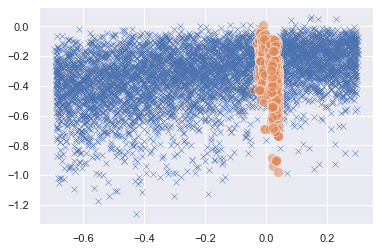

Epoch 1/2
634/634 [==============================] - 9s 13ms/step - loss: 0.1721 - val_loss: 0.1223
Epoch 2/2
634/634 [==============================] - 8s 13ms/step - loss: 0.0655 - val_loss: 0.1346
Dataset: PSD95pdz3
Protein: {'PSD95pdz3'}
Uniprot ID: {'P31016'}
Basename: {'P31016'}
val spearman: 0.28300031138801335 train spearman: 0.5856536503454705


/home/saul/tf2.4/lib/python3.8/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


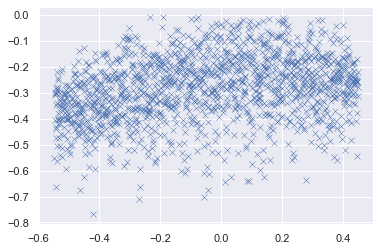

Epoch 1/2
645/645 [==============================] - 9s 13ms/step - loss: 0.3845 - val_loss: 0.0826
Epoch 2/2
645/645 [==============================] - 8s 12ms/step - loss: 0.0695 - val_loss: 0.0861
Dataset: Pab1
Protein: {'Pab1'}
Uniprot ID: {'P04147'}
Basename: {'P04147'}
val spearman: 0.3635308447160772 train spearman: 0.5209920538185464


/home/saul/tf2.4/lib/python3.8/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


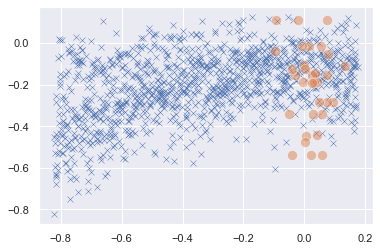

Epoch 1/2
514/514 [==============================] - 7s 14ms/step - loss: 0.5327 - val_loss: 0.0700
Epoch 2/2
514/514 [==============================] - 7s 13ms/step - loss: 0.0734 - val_loss: 0.0709
Dataset: beta-lactamase
Protein: {'TEM-1'}
Uniprot ID: {'P62593'}
Basename: {'P62593'}
val spearman: 0.399660829737969 train spearman: 0.5312446354896367


/home/saul/tf2.4/lib/python3.8/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


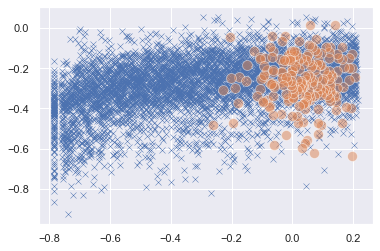

Epoch 1/2
608/608 [==============================] - 8s 13ms/step - loss: 0.2556 - val_loss: 0.0835
Epoch 2/2
608/608 [==============================] - 7s 12ms/step - loss: 0.0681 - val_loss: 0.1028
Dataset: E1_Ubiquitin
Protein: {'UBI4'}
Uniprot ID: {'P0CG63'}
Basename: {'P0CG63_1-76'}
val spearman: 0.27668180003173004 train spearman: 0.5544378642790809


/home/saul/tf2.4/lib/python3.8/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


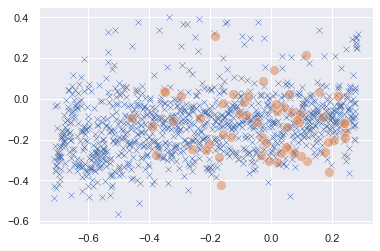

Dataset: Ubiquitin
Protein: {'UBI4'}
Uniprot ID: {'P0CG63'}


/home/saul/tf2.4/lib/python3.8/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


Basename: {'P0CG63_1-76'}
val spearman: 0.15752300127850982 train spearman: 0.5544378642790809


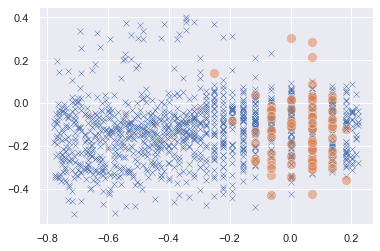

Epoch 1/2
671/671 [==============================] - 9s 12ms/step - loss: 0.2131 - val_loss: 0.0831
Epoch 2/2
671/671 [==============================] - 8s 12ms/step - loss: 0.0669 - val_loss: 0.0925
Dataset: WW_domain
Protein: {'Yap65'}
Uniprot ID: {'P46937'}
Basename: {'P46937'}
val spearman: 0.23073920549641788 train spearman: 0.5957062547087595


/home/saul/tf2.4/lib/python3.8/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


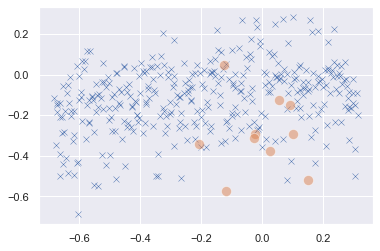

Epoch 1/2
651/651 [==============================] - 9s 13ms/step - loss: 0.6170 - val_loss: 0.0901
Epoch 2/2
651/651 [==============================] - 8s 12ms/step - loss: 0.0710 - val_loss: 0.0731
Dataset: gb1
Protein: {'gb1'}
Uniprot ID: {'P06654'}
Basename: {'P06654'}
val spearman: 0.3671669819126102 train spearman: 0.5625724850138688


/home/saul/tf2.4/lib/python3.8/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


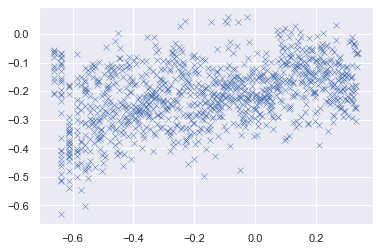

Epoch 1/2
551/551 [==============================] - 8s 14ms/step - loss: 0.2809 - val_loss: 0.0897
Epoch 2/2
551/551 [==============================] - 7s 13ms/step - loss: 0.0639 - val_loss: 0.1017
Dataset: hsp90
Protein: {'hsp90'}
Uniprot ID: {'P02829'}
Basename: {'P02829_2-231'}
val spearman: 0.2118940353204378 train spearman: 0.6029004968650067


/home/saul/tf2.4/lib/python3.8/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


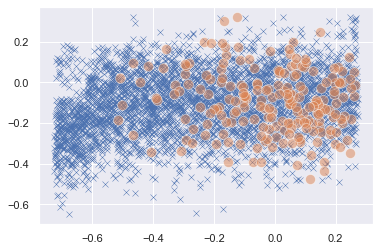

In [133]:
nn_params = {
    'epochs': 2,
            }
x = (x_cat, x_window)
lopo_plots_and_correlation(x, df, 'reported_fitness_quantile', nn_params)